In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Must import comet before torch, sometimes throws error otherwise.
from img_wang.callbacks import CometCallbackWithGrads
from fastai2.vision.all import show_image, show_images
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from htools import *
from img_wang.data import load_img, get_databunch, PatchworkDataset
from img_wang.models import Encoder, SingleInputBinaryModel, \
    TorchvisionEncoder
from img_wang.torch_utils import gpu_setup, n_out_channels
from incendio.callbacks import MetricHistory, ModelCheckpoint, EarlyStopper
from incendio.core import Trainer, DEVICE
from incendio.metrics import mean_soft_prediction, std_soft_prediction, percent_positive

/opt/conda/envs/fastai/lib/python3.7/site-packages/incendio/callbacks.py:25: UserWarning: Accio not available.
  warnings.warn('Accio not available.')


In [3]:
cd_root()
gpu_setup()

Current directory: /storage/img-wang
Setting seeds for reproducible training.


## DataLoader experiments

In [5]:
dst = PatchworkDataset('data/imagewang-160/unsup')
dl = DataLoader(dst, batch_size=64)

In [7]:
%%timeit -n 1 -r 1
for i, (x, y) in enumerate(dl):
    if i % 20 == 0: print(i)

0
20
40
60
80
100
120
44.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [24]:
dst = PatchworkDataset('data/imagewang-160/unsup')
dl = DataLoader(dst, batch_size=64, num_workers=2, drop_last=False)

In [25]:
%%timeit -n 1 -r 1
for i, (x, y) in enumerate(dl):
    if i % 20 == 0: print(i)

0
20
40
60
80
100
120
12.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [22]:
dst = PatchworkDataset('data/imagewang-160/unsup')
dl = DataLoader(dst, batch_size=64, num_workers=4, drop_last=False)

In [23]:
%%timeit -n 1 -r 1
for i, (x, y) in enumerate(dl):
    if i % 20 == 0: print(i)

0
20
40
60
80
100
120
6.14 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [20]:
dst = PatchworkDataset('data/imagewang-160/unsup')
dl = DataLoader(dst, batch_size=64, num_workers=8, drop_last=False)

In [21]:
%%timeit -n 1 -r 1
for i, (x, y) in enumerate(dl):
    if i % 20 == 0: print(i)

0
20
40
60
80
100
120
4.29 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [18]:
dst = PatchworkDataset('data/imagewang-160/unsup')
dl = DataLoader(dst, batch_size=512, num_workers=4, drop_last=False)

In [19]:
%%timeit -n 1 -r 1
for i, (x, y) in enumerate(dl):
    if i % 20 == 0: print(i)

0
8.75 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [4]:
# Slower with pin_memory=True. I think this may not be a fair comparison 
# though - we're not calling cuda() on any of the batches in part 1.
dst = PatchworkDataset('data/imagewang-160/unsup')
dl = DataLoader(dst, batch_size=512, num_workers=4, drop_last=False,
                pin_memory=True)

In [5]:
%%timeit -n 1 -r 1
for i, (x, y) in enumerate(dl):
    if i % 20 == 0: print(i)

0
13.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## Num Workers Experiments Pt 2

See what happens when we get the model involved and actually put images on the GPU.

Also used this to debug s01 issue "RuntimeError: non-empty 3D or 4D (batch mode) tensor expected for input".

In [4]:
dst, dsv, dlt, dlv = get_databunch('data/imagewang-160/unsup/', 
                                   mode='patchwork', bs=4, pct_pos=.5, 
                                   num_workers=8, pin_memory=True, 
                                   debug_mode=None)

In [5]:
# net = SingleInputBinaryModel(TorchvisionEncoder(), 
#                              nn.Linear(2560, 1))

# net = SingleInputBinaryModel(TorchvisionEncoder(pretrained=False), ps=.4)

net = SingleInputBinaryModel(
    TorchvisionEncoder('resnext50_32x4d', pretrained=False),
    ps=.4
)

# net = SingleInputBinaryModel(
#     TorchvisionEncoder('resnext101_32x8d', pretrained=False),
#     ps=.4
# )

# net = SingleInputBinaryModel(Encoder(), 
#                              nn.Linear(512, 1))

In [6]:
# resnext50_32x4d: 25,086,784
# resnext101_32x8d: 88,849,216
net.numel()

25086784

In [7]:
# resnext50_32x4d: 64
# resnext101_32x8d: 64
sys.getsizeof(net)

64

In [8]:
# resnext50_32x4d: 622 MB
# resnext101_32x8d: 866 MB (see nvidia-smi)
net.to(DEVICE)

SingleInputBinaryModel(
  (groups): Sequential(
    (0): TorchvisionEncoder(
      (model): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (4): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1,

In [50]:
xb, yb = next(iter(dlt))

In [51]:
yh = net.groups[0](xb)
yh.shape

torch.Size([4, 2048, 4, 4])

In [53]:
yh = net(xb)
yh.shape

torch.Size([4, 1])

In [46]:
net.unfreeze(n_groups=2)

In [13]:
t = Trainer(net, dst, dsv, dlt, dlv, F.binary_cross_entropy_with_logits,
            mode='binary', out_dir='data/models/tmp', last_act=torch.sigmoid,
            metrics=[mean_soft_prediction, std_soft_prediction, percent_positive])
t.fit(3, [1e-5, 1e-4, 1e-4])

2020-09-14 03:32:00,180 [INFO]: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 0.001
    lr: 1e-05
    weight_decay: 0

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 0.001
    lr: 0.0001
    weight_decay: 0

Parameter Group 2
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 0.001
    lr: 0.0001
    weight_decay: 0
)




=====

Epoch 0

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  0.7106 |       0.6803 |
| mean_soft_prediction |  0.4936 |       0.5954 |
| std_soft_prediction  |  0.1292 |       0.1211 |
| percent_positive     |  0.4760 |       0.7806 |





=====

Epoch 1

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  0.6403 |       0.6572 |
| mean_soft_prediction |  0.4955 |       0.6327 |
| std_soft_prediction  |  0.1397 |       0.1498 |
| percent_positive     |  0.4932 |       0.7910 |





=====

Epoch 2

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  0.5927 |       0.6175 |
| mean_soft_prediction |  0.4968 |       0.6327 |
| std_soft_prediction  |  0.1719 |       0.1854 |
| percent_positive     |  0.5038 |       0.7419 |


Training complete. Model in eval mode.


## Cleaned up and ported DS

In [7]:
dst, dsv, dlt, dlv = get_databunch('data/imagewang-160/unsup/', 
                                   mode='patchwork', bs=9, pct_pos=.5, 
                                   max_train_len=None, max_val_len=None, 
                                   debug_mode=None, flip_vert_p=.5, 
                                   flip_horiz_p=.5, rand_noise_p=.5, 
                                   noise_std=.05)

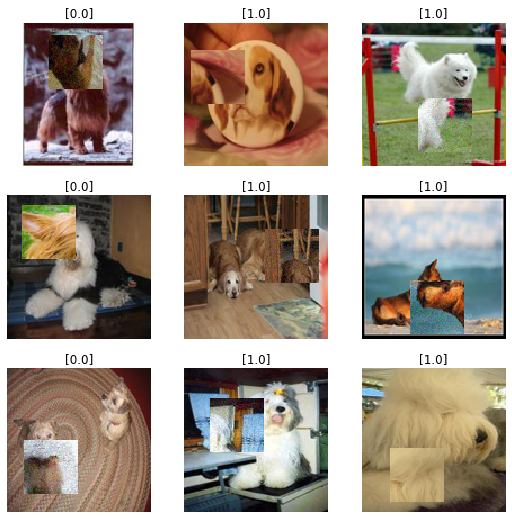

In [8]:
xb, yb = next(iter(dlt))
show_images(xb[:9], nrows=3, titles=yb[:9].tolist())

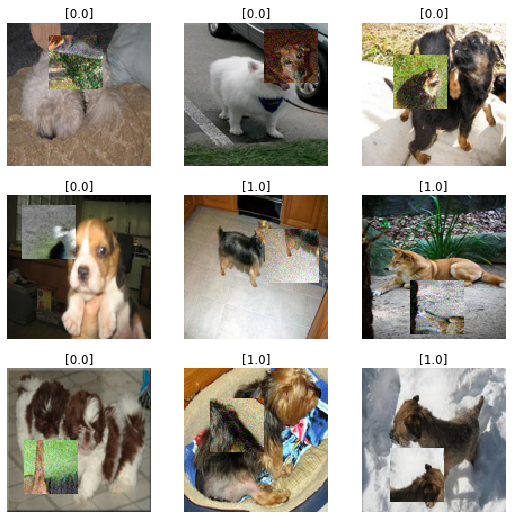

In [9]:
xv, yv = next(iter(dlv))
show_images(xv[:9], nrows=3, titles=yv[:9].tolist())

In [13]:
# net = SingleInputBinaryModel(TorchvisionEncoder(), 
#                              nn.Linear(2560, 1))

net = SingleInputBinaryModel(Encoder(), 
                             nn.Linear(512, 1))

In [14]:
t = Trainer(net, dst, dsv, dlt, dlv, F.binary_cross_entropy_with_logits,
            mode='binary', out_dir='data/models/tmp', last_act=torch.sigmoid,
            metrics=[mean_soft_prediction, std_soft_prediction, percent_positive])
t.fit(2, [1e-5, 1e-4, 1e-4])

2020-09-12 05:15:03,508 [INFO]: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 0.001
    lr: 1e-05
    weight_decay: 0

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 0.001
    lr: 0.0001
    weight_decay: 0

Parameter Group 2
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 0.001
    lr: 0.0001
    weight_decay: 0
)




=====

Epoch 0

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  0.7061 |       0.6931 |
| mean_soft_prediction |  0.5343 |       0.4969 |
| std_soft_prediction  |  0.0589 |       0.0001 |
| percent_positive     |  0.7257 |       0.0000 |





=====

Epoch 1

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  0.6994 |       0.6931 |
| mean_soft_prediction |  0.4694 |       0.5045 |
| std_soft_prediction  |  0.0688 |       0.0001 |
| percent_positive     |  0.3429 |       1.0000 |


Training complete. Model in eval mode.


Search notes/misc.txt for "Batch size experiments" to view notes on the results.